In [2]:
import sklearn
import pandas as pd
import numpy as np
import json
from matplotlib.legend_handler import HandlerLine2D
import matplotlib.pyplot as plt

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report, auc, roc_curve
from imblearn.pipeline import Pipeline as pipe

In [5]:
json_data = json.load(open('challenge.json')) #will need to change to where you have the file

In [6]:
df = pd.DataFrame(json_data)

In [7]:
df.head()

,branch_id,customer_code,group_code,is_churn,item_code,item_total_price,order_id,quantity,register_date,sales_channel,segment_code,seller_code,total_price,unit_price
0,0,143,0,0,854,292.91,21804,10,2017-11-10T00:00:00Z,0,0,190,1613.53,25.04
1,0,433,0,0,246,287.19,5486,20,2011-05-16T00:00:00Z,1,5,153,11163.69,12.33
2,0,486,0,0,1420,184.84,22662,12,2018-01-24T00:00:00Z,0,0,166,6432.12,12.80
3,0,107,0,0,1963,189.18,3956,18,2010-07-28T00:00:00Z,1,0,156,831.82,10.51
4,0,768,0,0,1786,66.87,4730,5,2010-12-17T00:00:00Z,1,0,218,1736.48,11.82


In [8]:
import datetime
now = datetime.datetime.now()

In [9]:
print(now)

2019-08-22 16:25:01.494742


In [10]:
df['date'] = pd.to_datetime(df['register_date'])
df['date_notz'] = df['date'].dt.tz_localize(None)

In [11]:
df['years_active'] = ((now - df['date_notz']).dt.days)/365.0

In [12]:
df_drop = df.drop(['customer_code', 'order_id', 'register_date','date', 'date_notz'],axis=1) #drop unsued columns

In [14]:
df_drop = df_drop.drop('branch_id',axis=1)

In [15]:
df_drop.head()

,group_code,is_churn,item_code,item_total_price,quantity,sales_channel,segment_code,seller_code,total_price,unit_price,years_active
0,0,0,854,292.91,10,0,0,190,1613.53,25.04,1.780822
1,0,0,246,287.19,20,1,5,153,11163.69,12.33,8.273973
2,0,0,1420,184.84,12,0,0,166,6432.12,12.80,1.575342
3,0,0,1963,189.18,18,1,0,156,831.82,10.51,9.073973
4,0,0,1786,66.87,5,1,0,218,1736.48,11.82,8.684932


In [16]:
len(df_drop['item_code'].unique())

2981

In [17]:
#Rather than attempt to encode branch, group, item, channel, segment, and seller 
#I will create oods ratios based off "churn rate"
#These ratios will be stored in a dictionary and used to replace the categorical values
#To reduce cardinality of item_code, sales_channel, seller_code: 
#I will only calculate this number if the value falls into the 68% of data described
#Otherwise it will be lumped in to "other"
#If a value is unknown to the hashmap then it will fall in to "other" 
#and be given that churn rate
#But first... split into train/test so we avoid data leakage

In [18]:
train_df = df_drop.sample(frac=0.75, random_state=1019)
test_df = df_drop.drop(train_df.index)

In [19]:
train_df['item_code'][train_df['item_code'] < train_df['item_code'].quantile(0.68)] = 'Unknown'

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [20]:
train_df['sales_channel'][train_df['sales_channel'] < train_df['sales_channel'].quantile(0.68)] = 'Unknown'

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [21]:
train_df['seller_code'][train_df['seller_code'] < train_df['seller_code'].quantile(0.68)] = 'Unknown'

/srv/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [22]:
train_df.head()

,group_code,is_churn,item_code,item_total_price,quantity,sales_channel,segment_code,seller_code,total_price,unit_price,years_active
64272,0,0,Unknown,59.81,1,Unknown,5,201,2400.09,59.81,5.378082
161495,2,1,Unknown,320.70,5,7,2,Unknown,489.75,56.32,3.076712
26892,2,1,Unknown,4.62,3,2,2,190,539.11,1.54,8.153425
124690,2,1,Unknown,320.70,5,7,2,Unknown,1085.70,56.32,3.742466
14753,0,0,Unknown,119.88,4,Unknown,0,Unknown,2804.63,29.97,1.978082


In [23]:
len(train_df['item_code'].unique())

1034

In [24]:
#much better!

In [25]:
#create the look up dictionary of odds rations/binned data/churn rates for the high cardnality features
def churn_dict(col,df):
    #calculated using training data only
    churn_rate = {}
    
    for uid, grp in df.groupby(col):
        uid = str(uid)
        churn_rate[uid] = float(len(grp[grp.is_churn == '1'])) / float(len(grp)) #churn rate
    
    return churn_rate

In [26]:
#create lookup dictionaries
item_dict = churn_dict('item_code',train_df)
channel_dict = churn_dict('sales_channel',train_df)
seller_dict = churn_dict('seller_code',train_df)

In [27]:
#mask and reassign columns
seller_code_masked = train_df['seller_code'].astype(str).replace(seller_dict)
train_df['seller_code'] = seller_code_masked

In [28]:
item_code_masked = train_df['item_code'].astype(str).replace(item_dict)
train_df['item_code'] = item_code_masked

In [29]:
channel_code_masked = train_df['sales_channel'].astype(str).replace(channel_dict)
train_df['sales_channel'] = channel_code_masked

In [30]:
#mask and re-assign testing data
seller_code_masked_test = test_df['seller_code'].astype(str).replace(seller_dict)
item_code_masked_test = test_df['item_code'].astype(str).replace(item_dict)
channel_code_masked_test = test_df['sales_channel'].astype(str).replace(channel_dict)

In [31]:
#in the above step: if the value wasn't replaced by the dictionary because the test set hadn't seen the val, 
#it will be >1 (as it's still the original code), so we can replace it with the 'Unknown' churn rate

In [32]:
#note, i don't like having to copy and paste this, if i had more time i'd make this a class of functions that scales
test_df['seller_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in seller_code_masked_test]
test_df['item_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in item_code_masked_test]
test_df['channel_code'] = [seller_dict['Unknown'] if i > 1.0 else i for i in channel_code_masked_test]

In [33]:
#now that i have engineered some features, i will train a logistic regession (i'm going to
#go with a gradient booster as I've had good expereince using this algorithm on imbalnced classes)
#with a few different learning rates before baking the final model
#my end reault here would be to find those customers we think are about to churn 
#(i.e. we classify them as churn but they aren't)and reach out to them to offer a sale/incentive

In [34]:
#isolate target label
y_train = train_df['is_churn'].values 
X_train = train_df.drop('is_churn',axis=1)

In [35]:
y_train = [0 if i is None else i for i in y_train] #get rid of nans
y_train = [int(i) for i in y_train] #make sure labels are numbers

In [36]:
#isolate target label
y_test = test_df['is_churn'].values
X_test = test_df.drop('is_churn',axis=1)

In [37]:
y_test = [0 if i is None else i for i in y_test] #get rid of nans
y_test = [int(i) for i in y_test] #make sure labels are numbers

In [38]:
def transform_pipeline(cols):
    
    si_step = ('si',SimpleImputer(strategy='median'))

    steps = [si_step]
    trans_pipe = Pipeline(steps)

    transformers = [('all_cols', trans_pipe, cols)]
    
    ct = ColumnTransformer(transformers=transformers)
    return ct

In [39]:
cols = list(X_train.columns)

In [40]:
#transform data with simplute imputer
ct = transform_pipeline(cols)

In [42]:
#fit transform train and transform test 
X_train_trans = ct.fit_transform(X_train)
X_test_trans = ct.transform(X_test)

In [43]:
#tuning of gradient booster params lies below!

In [44]:
learning_rates = [1.5, 1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

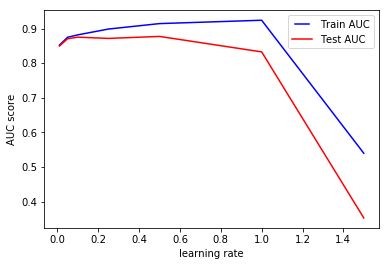

In [45]:
line1, = plt.plot(learning_rates, train_results, 'b', label='Train AUC')
line2, = plt.plot(learning_rates, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('learning rate')
plt.show()

In [46]:
best_rate = 0.05

In [47]:
estimators = [1,2,4,8,16,32,64,100,200]
train_results = []
test_results = []
for est in estimators:
    model = GradientBoostingClassifier(n_estimators=est)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

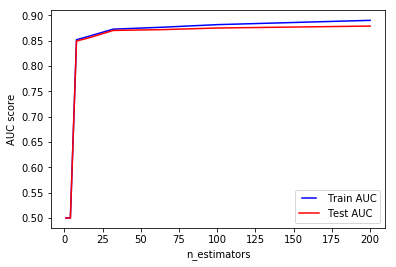

In [48]:
line1, = plt.plot(estimators, train_results, 'b', label='Train AUC')
line2, = plt.plot(estimators, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

In [49]:
best_est = 32

In [50]:
min_splits = np.linspace(0.1,1.0,10,endpoint=True)
train_results = []
test_results = []
for split in min_splits:
    model = GradientBoostingClassifier(min_samples_split=split)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

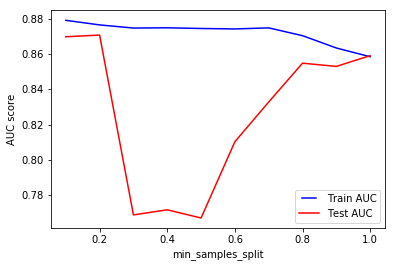

In [51]:
line1, = plt.plot(min_splits, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_splits, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_split')
plt.show()

In [52]:
best_split = 0.2

In [53]:
min_samples_leafs = np.linspace(0.1,0.5,5,endpoint=True)
train_results = []
test_results = []
for leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=leaf)
    model.fit(X_train_trans, y_train)
    train_pred = model.predict(X_train_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_test_trans)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

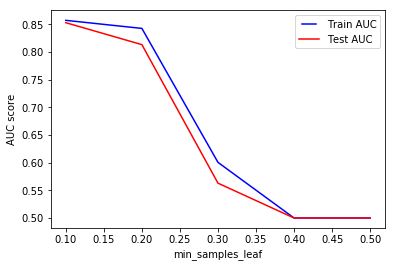

In [54]:
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min_samples_leaf')
plt.show()

In [55]:
best_leaf = 0.15

In [56]:
#define the ml pipeline using params from above. 
#i begin with a standard scale step, i won't be using PCA as there are only 10 features
def ml_pipeline():
    ss_step = ('ss', StandardScaler(with_mean=True))

    gb_step = ('gb',GradientBoostingClassifier(learning_rate = 0.05,
                                              n_estimators=best_est,
                                              max_depth=5, 
                            # i chose a max_depth automatically based on experience and time constraints
                                              min_samples_split=best_split,
                                              min_samples_leaf=best_leaf))
    
    pipeline_steps = [ss_step, gb_step]
    
    ml_pipe = pipe(pipeline_steps)
    
    return ml_pipe

In [57]:
ml_pipe = ml_pipeline()

In [58]:
#fit to train
ml_pipe.fit(X_train_trans,y_train)

Pipeline(memory=None,
         steps=[('ss',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gb',
                 GradientBoostingClassifier(criterion='friedman_mse', init=None,
                                            learning_rate=0.05, loss='deviance',
                                            max_depth=5, max_features=None,
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=0.15,
                                            min_samples_split=0.2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=32,
                                            n_iter_no_change=None,
                                            presort='auto', random_state=None

In [59]:
#predict on test
y_pred = ml_pipe.predict(X_test_trans)
y_prob = ml_pipe.predict_proba(X_test_trans)[:,1]

In [60]:
#metrics

In [61]:
cr = classification_report(y_test,y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     41459
           1       0.80      0.71      0.75      9648

    accuracy                           0.91     51107
   macro avg       0.87      0.83      0.85     51107
weighted avg       0.91      0.91      0.91     51107



In [62]:
cm = confusion_matrix(y_test,y_pred)
print(cm)

[[39753  1706]
 [ 2791  6857]]


In [63]:
#This seems to be a large number of flase positives creating a large caseload. This caseload may be difficult if actual 
#people will be targeting these customers to offere incentives, but if it's an email blast it may not be cumbersome.
#I'm okay with these results for now as the weight f1-score is 91.

In [67]:
import seaborn as sns

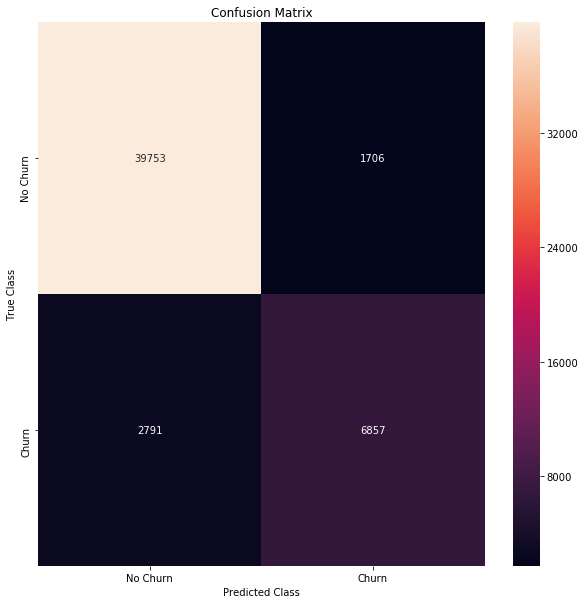

In [70]:
def plot_cm(cm):
    labels = ['No Churn','Churn']
    plt.figure(figsize=(10,10))
    sns.heatmap(cm,xticklabels=labels,yticklabels=labels,annot=True,fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.show

plot_cm(cm)

In [71]:
fpr, tpr, thresholds = roc_curve(y_test,y_prob)
roc_auc = auc(fpr,tpr)

In [72]:
def plot_roc(fpr, tpr, thresholds,roc_auc):
    plt.figure(figsize=(15,8))
    plt.title('Receiver Operating Characteristic AUC')
    plt.plot(fpr,tpr,'b',label='AUC = %0.2f'%roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

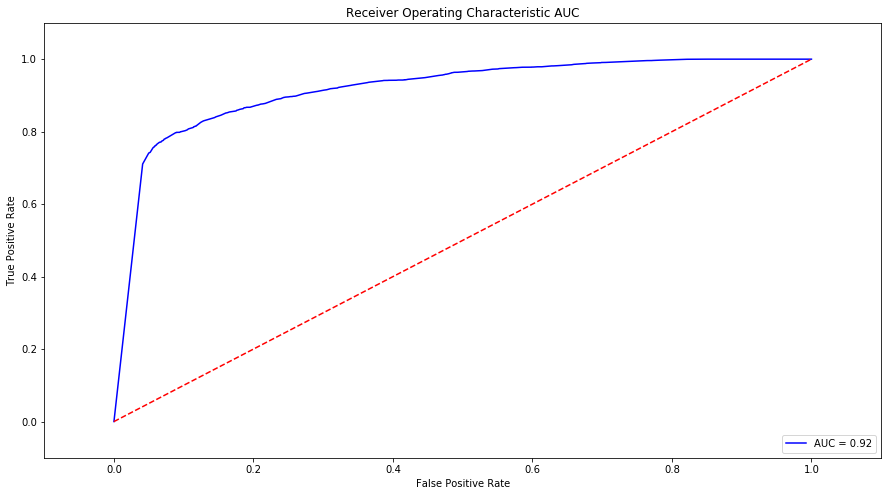

In [73]:
plot_roc(fpr, tpr, thresholds,roc_auc)

In [75]:
#The area under the curve is high, but not so high that I'm worried about overfitting.
# In the end this took me most of yesterday afternoon (with breaks to do so family things)
#And part of this morning. Including one catastrophe where I lost all my work a few hours ago.
#Thank you for this challenge and for considering my application.